# Optimization algorithms for linear regression

In [1]:
# importing necessary libraries

import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import torch
import pandas as pd

from prml.preprocess import GaussianFeature, PolynomialFeature, SigmoidalFeature
from prml.linear import (
    BayesianRegression,
    EmpiricalBayesRegression,
    LinearRegression,
    RidgeRegression
)

In [8]:
# creating the data points from the Engineering AI Agents Github

def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = torch.linspace(domain[0], domain[1], sample_size)
    x = x[torch.randperm(x.size(0))]  # Shuffle x
    y = func(x) + torch.normal(mean=0, std=std, size=x.shape)
    return x, y

def sinusoidal(x):
    return torch.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = torch.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

x_test, y_test

(tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
         0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
         0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
         0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
         0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
         0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
         0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
         0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
         0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
         0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
         0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
         1.0000]),
 tensor([ 0.0000e+00,  6.3424e-02,  1.2659e-01,  1.8925e-01,  2.5115e-01,
          3.1203

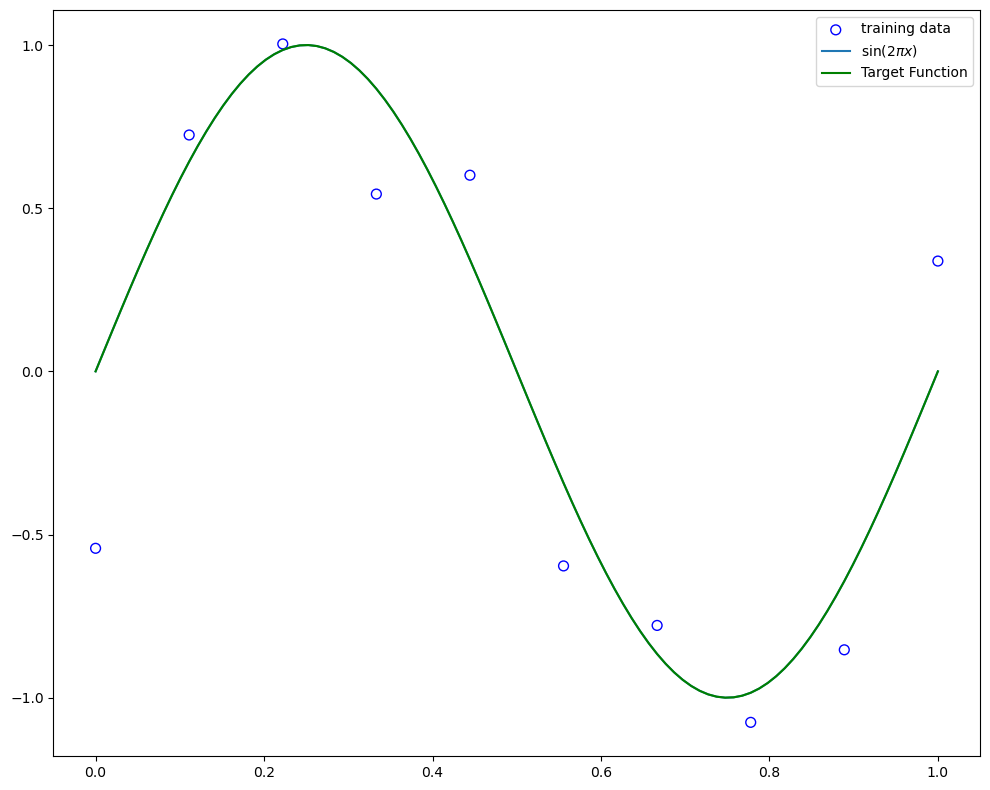

In [9]:
# plotting the given model

plt.figure(figsize=[10,8])
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y_test, "-g", label="Target Function")
plt.legend()
plt.tight_layout()
plt.show()

## Task - 1 (Stochastic Gradient Descent)

Linear Regression
$$
y = X \beta + \epsilon
$$

Loss Function (MSE)
$$
L(\beta) = \frac{1}{n} \sum_{i=1}^{n} (y_i - X_i \beta)^2
$$

Gradient of Loss Function
$$
\nabla L(\beta) = -\frac{2}{n} X^T (y - X \beta)
$$

Update Rule
$$
\beta := \beta - \alpha \nabla L(\beta)
$$

In [153]:
# coding the stochastic gradient descent

# I am not using procedural code, I think it is better to implement it using classes, 
# just to make the code clear and easy to understand

class RegularizedLinearRegression:
    
        # class constructor with all the hyperparameters
        def __init__(self, degree, learning_rate, num_epochs=1000, lambda_reg=0.01, batch_size=1):
            self.degree = degree
            self.learning_rate = learning_rate
            self.num_epochs = num_epochs
            self.lambda_reg = lambda_reg
            self.batch_size = batch_size
            self.w = None
            self.b = None
        
        # polynomial features
        def add_polynomial_features(self, x):
            return torch.stack([x**i for i in range(1, self.degree + 1)], dim=1)

        def fit(self, x_train, y_train):
            
            # adding polynomial features
            X_train_poly = self.add_polynomial_features(x_train)
            
            # simply reshaping y_train was giving warning, so I am using clone method
            y_train = y_train.reshape(-1, 1).clone().detach().to(dtype=torch.float32)


            num_features = X_train_poly.shape[1]
            self.w = torch.randn(num_features, 1, requires_grad=True)
            self.b = torch.zeros(1, requires_grad=True)

            losses = []
            num_samples = X_train_poly.shape[0]
            
            # although we are using batch size of 1, but I wanted the code to be more general
            num_batches = num_samples // self.batch_size

            for epoch in range(self.num_epochs):
                epoch_loss = 0
                # Shuffle the data
                permutation = torch.randperm(num_samples)
                X_train_shuffled = X_train_poly[permutation]
                y_train_shuffled = y_train[permutation]

                for i in range(num_batches):
                    
                    # for code to be more general
                    start_idx = i * self.batch_size
                    end_idx = start_idx + self.batch_size

                    X_batch = X_train_shuffled[start_idx:end_idx]
                    y_batch = y_train_shuffled[start_idx:end_idx]

                    y_pred = torch.matmul(X_batch, self.w) + self.b
                    loss = torch.mean((y_pred - y_batch)**2) + self.lambda_reg * torch.sum(self.w**2)

                    epoch_loss += loss.item()
                    # Manual gradient calculation
                    errors = y_pred - y_batch
                    grad_w = (2 / len(y_batch)) * torch.matmul(X_batch.T, errors) + 2 * self.lambda_reg * self.w
                    grad_b = (2 / len(y_batch)) * torch.sum(errors)

                    # Update parameters
                    with torch.no_grad():
                        self.w -= self.learning_rate * grad_w
                        self.b -= self.learning_rate * grad_b


                avg_epoch_loss = epoch_loss / num_batches
                losses.append(avg_epoch_loss)

            plt.figure(figsize=(10, 5))
            plt.plot(range(self.num_epochs), losses)
            plt.title('Loss vs Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()

        def predict(self, x):
            X_poly = self.add_polynomial_features(x)
            with torch.no_grad():
                return torch.matmul(X_poly, self.w) + self.b

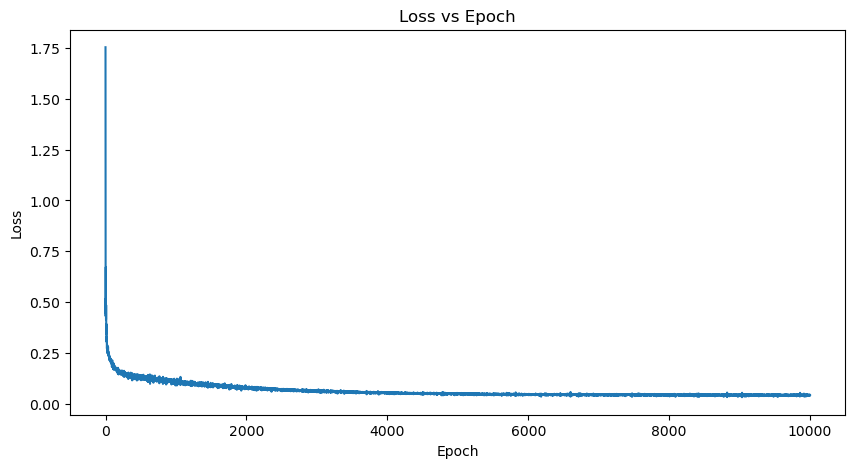

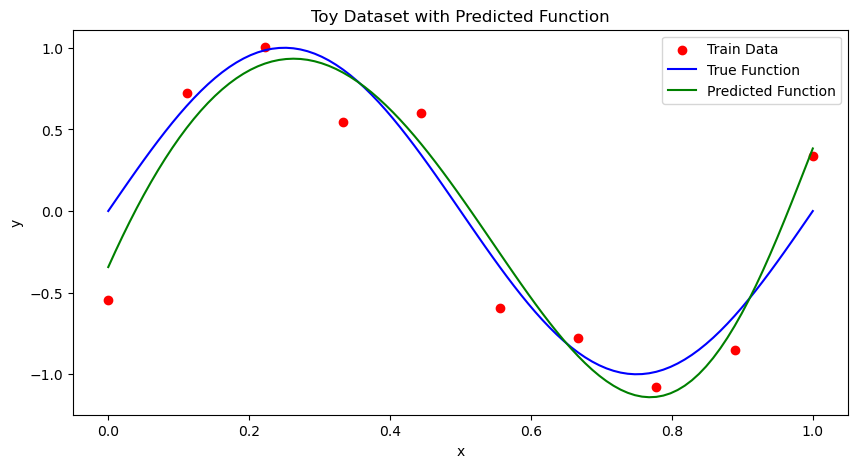

In [265]:
# Hyperparameters

degree = 9
learning_rate = 0.07
epochs = 10000
lambda_reg = 0
batch_size = 1

model = RegularizedLinearRegression(degree, learning_rate, epochs, lambda_reg, batch_size)
model.fit(x_train, y_train)

y_pred_test = model.predict(x_test)

plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, color='red', label='Train Data')
plt.plot(x_test, y_test, color='blue', label='True Function')
plt.plot(x_test, y_pred_test, color='green', label='Predicted Function')
plt.title('Toy Dataset with Predicted Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

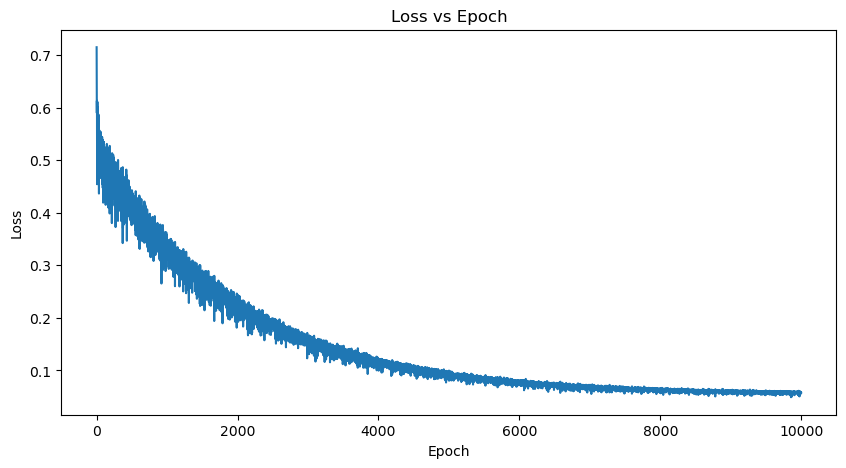

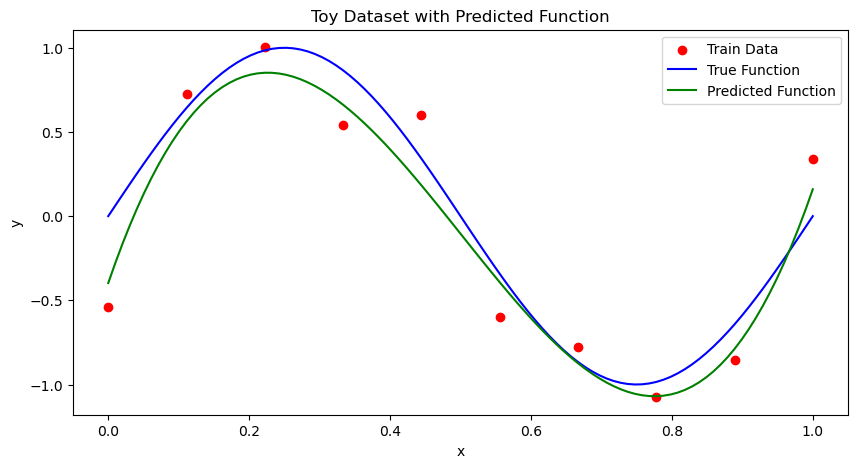

In [216]:
# Hyperparameters

degree = 3
learning_rate = 0.07
epochs = 10000
lambda_reg = 0.00001
batch_size = 1

model = RegularizedLinearRegression(degree, learning_rate, epochs, lambda_reg, batch_size)
model.fit(x_train, y_train)

y_pred_test = model.predict(x_test)

plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, color='red', label='Train Data')
plt.plot(x_test, y_test, color='blue', label='True Function')
plt.plot(x_test, y_pred_test, color='green', label='Predicted Function')
plt.title('Toy Dataset with Predicted Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

##### Results and Conclussion:

The model is able to fit the data well. The learning rate is 0.07 and epoch was 10000, while lambda_reg was 0.00001 and degree was 3 .

## Task - 2 (Momentum)

The hypothesis is given by the following equation,
$$
\hat{y} = xw + b
$$

The Loss function (MSE with L-2 Regularisation)
$$
L = \frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^m w_j^2
$$

Gradient of Loss with respect to W (Weights)
$$
\frac{\partial L}{\partial w} = -\frac{2}{n}X^T(y - \hat{y}) + 2\lambda w
$$

Gradient of Loss with respect to B (Bias)
$$
\frac{\partial L}{\partial b} = -\frac{2}{n}\sum_{i=1}^n (y_i - \hat{y}_i)
$$

Velocity Update for Weights
$$
v_{w} = \gamma v_{w_{t-1}} + \alpha\frac{\partial L}{\partial w}
$$

Velocity Update for Bias
$$
v_{b} = \gamma v_{b_{t-1}} + \alpha\frac{\partial L}{\partial b}
$$

Weight update rule
$$
w_{t+1} = w_t - v_{w}
$$

Bias update rule
$$
b_{t+1} = b_t - v_{b}
$$

In [217]:
# coding the stochastic gradient descent with momentum optimisation

# I am not using procedural code, I think it is better to implement it using classes, 
# just to make the code clear and easy to understand


class RegularizedLinearRegressionWithMomentum:
    
    def __init__(self, degree, learning_rate=0.01, num_epochs=1000, lambda_reg=0.01, momentum=0.9, batch_size=1):
        self.degree = degree
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.lambda_reg = lambda_reg
        self.momentum = momentum
        self.batch_size = batch_size
        self.w = None
        self.b = None
    
    # polynomial features
    def add_polynomial_features(self, x):
        return torch.cat([x.pow(i) for i in range(1, self.degree + 1)], dim=1)
    
    def fit(self, x_train, y_train):
        
        # adding polynomial features
        X_train_poly = self.add_polynomial_features(x_train.view(-1, 1))
        
        # simply reshaping y_train was giving warning, so I am using clone method
        y_train = y_train.reshape(-1, 1).clone().detach().to(dtype=torch.float32)

        num_features = X_train_poly.shape[1]
        self.w = torch.randn(num_features, 1, requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)
        
        v_w = torch.zeros_like(self.w)
        v_b = torch.zeros_like(self.b)

        losses = []
        num_samples = X_train_poly.shape[0]
        num_batches = num_samples // self.batch_size

        for epoch in range(self.num_epochs):
            epoch_loss = 0
            # Shuffle the data
            permutation = torch.randperm(num_samples)
            X_train_shuffled = X_train_poly[permutation]
            y_train_shuffled = y_train[permutation]

            for i in range(num_batches):
                start_idx = i * self.batch_size
                end_idx = start_idx + self.batch_size
                
                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]

                y_pred = torch.matmul(X_batch, self.w) + self.b
                loss = torch.mean((y_pred - y_batch)**2) + self.lambda_reg * torch.sum(self.w**2)
                epoch_loss += loss.item()
                
                # Manual gradient calculation
                errors = y_pred - y_batch
                grad_w = (2 / len(y_batch)) * torch.matmul(X_batch.T, errors) + 2 * self.lambda_reg * self.w
                grad_b = (2 / len(y_batch)) * torch.sum(errors)

                # Update parameters with momentum
                with torch.no_grad():
                    v_w = self.momentum * v_w + self.learning_rate * grad_w
                    v_b = self.momentum * v_b + self.learning_rate * grad_b 
                    self.w -= v_w
                    self.b -= v_b

            avg_epoch_loss = epoch_loss / num_batches
            losses.append(avg_epoch_loss)

        plt.figure(figsize=(10, 5))
        plt.plot(range(self.num_epochs), losses)
        plt.title('Loss vs Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    def predict(self, x):
        X_poly = self.add_polynomial_features(x.view(-1, 1))
        with torch.no_grad():
            return torch.matmul(X_poly, self.w) + self.b

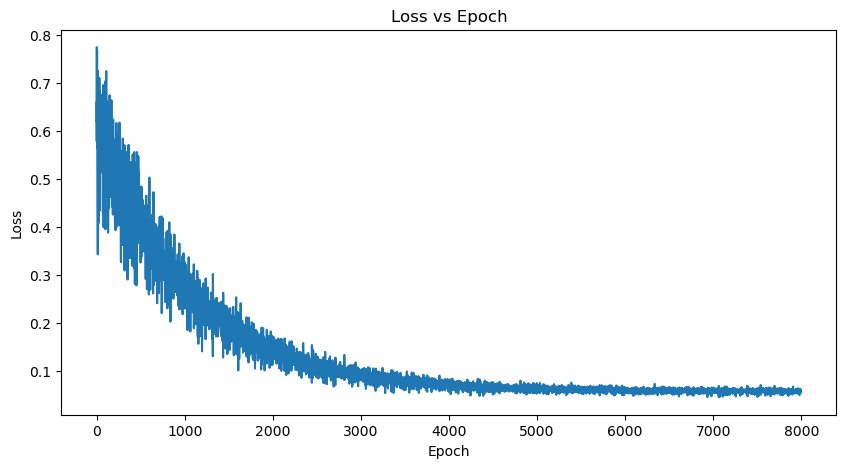

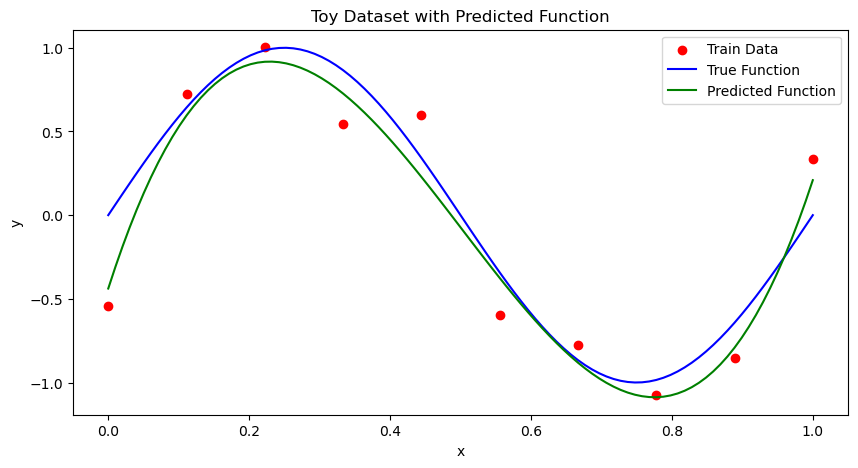

In [235]:
# Hyperparameters

degree = 3
learning_rate = 0.09
epochs = 8000
lambda_reg = 0.00001
batch_size = 1
momentum = 0.3

model = RegularizedLinearRegressionWithMomentum(degree, learning_rate, epochs, lambda_reg, momentum, batch_size)
model.fit(x_train, y_train)

y_pred_test = model.predict(x_test)

plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, color='red', label='Train Data')
plt.plot(x_test, y_test, color='blue', label='True Function')
plt.plot(x_test, y_pred_test, color='green', label='Predicted Function')
plt.title('Toy Dataset with Predicted Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Results and Conclussion:

The model is able to fit the data well. The learning rate is 0.09 and epoch was 8000, while lambda_reg was 0.00001 and momentum was 0.3.

# Logistic Regression

## Task 1 (Data Preprocessing)

Reading dataset in chunks.

In [16]:
# Function to read the data in chunks, as the dataset is too large, I am getting memory error.
# So, I am using chunks to read the data
def read_data_in_chunks(file_path, chunksize=100000):
    chunks = pd.read_csv(file_path, compression='gzip', chunksize=chunksize)
    return pd.concat(chunks, ignore_index=True)

# Read the data
df = read_data_in_chunks('./Datasets/train.gz')

I am taking out 1,000,000 samples from the original datatset, keeping the class ratios same as the original dataset.

In [17]:
# The original class distribution
class_distribution = df['click'].value_counts(normalize=True)

# Calculate the number of samples for each class
n_samples = 1000000
samples_per_class = (class_distribution * n_samples).astype(int)

# Sample from each class
sampled_df = df.groupby('click', group_keys=False).apply(lambda x: x.sample(n=samples_per_class[x.name]))

# Shuffle the sampled dataframe
sampled_df = sampled_df.sample(frac=1).reset_index(drop=True)

print(f"Original class distribution:\n{class_distribution}")
print(f"\nSampled class distribution:\n{sampled_df['click'].value_counts(normalize=True)}")
print(f"\nNumber of sampled rows: {len(sampled_df)}")

Original class distribution:
0    0.830194
1    0.169806
Name: click, dtype: float64

Sampled class distribution:
0    0.830195
1    0.169805
Name: click, dtype: float64

Number of sampled rows: 999999


In [18]:
sampled_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,6.083712e+18,0,14102111,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,1,0,4687,320,50,423,2,39,-1,32
1,1.347089e+19,0,14103004,1005,0,85f751fd,c4e18dd6,50e219e0,d36838b1,0e8616ad,...,1,0,23804,320,50,2726,3,803,-1,229
2,1.240887e+19,1,14103007,1002,0,203b00f1,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,0,0,23438,320,50,2684,2,1327,100004,52
3,1.202423e+19,0,14103013,1005,1,88154ade,9f448720,3e814130,ecad2386,7801e8d9,...,1,0,17894,320,50,2039,2,39,-1,32
4,1.533390e+19,0,14102103,1005,0,030440fe,08ba7db9,76b2941d,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [19]:
# columns like id, hour, device_id or device_ip will have no coorelation to the output label
# so, dropping the columns that are not needed
columns_to_drop = ['id', 'hour', 'device_id', 'device_ip', 'device_model']
sampled_df = sampled_df.drop(columns_to_drop, axis=1)

In [20]:
sampled_df.head()

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,0f2161f8,1,0,4687,320,50,423,2,39,-1,32
1,0,1005,0,85f751fd,c4e18dd6,50e219e0,d36838b1,0e8616ad,0f2161f8,1,0,23804,320,50,2726,3,803,-1,229
2,1,1002,0,203b00f1,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,0,0,23438,320,50,2684,2,1327,100004,52
3,0,1005,1,88154ade,9f448720,3e814130,ecad2386,7801e8d9,07d7df22,1,0,17894,320,50,2039,2,39,-1,32
4,0,1005,0,030440fe,08ba7db9,76b2941d,ecad2386,7801e8d9,07d7df22,1,0,18993,320,50,2161,0,35,-1,157


In [21]:
sampled_df.value_counts()

click  C1    banner_pos  site_id   site_domain  site_category  app_id    app_domain  app_category  device_type  device_conn_type  C14    C15  C16  C17   C18  C19   C20      C21
0      1005  0           85f751fd  c4e18dd6     50e219e0       febd1138  82e27996    0f2161f8      1            0                 21611  320  50   2480  3    297    100111  61     10835
                                                               e2fcccd2  5c5a694b    0f2161f8      1            0                 4687   320  50   423   2    39     100148  32      7019
             1           e151e245  7e091613     f028772b       ecad2386  7801e8d9    07d7df22      1            0                 4687   320  50   423   2    39     100148  32      6715
             0           85f751fd  c4e18dd6     50e219e0       92f5800b  ae637522    0f2161f8      1            3                 21191  320  50   2424  1    161    100193  71      5838
                                                                               

In [22]:
sampled_df.describe()

,click,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
mean,0.169805,1004.967523,0.287964,1.015152,0.331386,18845.576984,318.879395,60.059882,2112.903542,1.432636,227.371737,53288.575576,83.418814
std,0.375462,1.092542,0.506309,0.526157,0.854210,4953.695947,21.133310,47.124413,608.914931,1.326576,351.310266,49952.293906,70.334355
min,0.000000,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000
25%,0.000000,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,23.000000
50%,0.000000,1005.000000,0.000000,1.000000,0.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,100050.000000,61.000000
75%,0.000000,1005.000000,1.000000,1.000000,0.000000,21894.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,100094.000000,101.000000
max,1.000000,1012.000000,7.000000,5.000000,5.000000,24043.000000,1024.000000,1024.000000,2757.000000,3.000000,1839.000000,100248.000000,255.000000


Converting vategorical data to numerical using 'pd.factorize' .

In [23]:
# categorical columns
categorical_columns = sampled_df.select_dtypes(include=['object']).columns
categorical_columns

Index(['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain',
       'app_category'],
      dtype='object')

In [24]:
# convert categorical columns to numeric values
for column in categorical_columns:
    sampled_df[column] = pd.factorize(sampled_df[column])[0]

In [25]:
sampled_df.head()

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,1005,0,0,0,0,0,0,0,1,0,4687,320,50,423,2,39,-1,32
1,0,1005,0,0,0,0,1,1,0,1,0,23804,320,50,2726,3,803,-1,229
2,1,1002,0,1,0,0,2,2,1,0,0,23438,320,50,2684,2,1327,100004,52
3,0,1005,1,2,1,1,2,2,1,1,0,17894,320,50,2039,2,39,-1,32
4,0,1005,0,3,2,2,2,2,1,1,0,18993,320,50,2161,0,35,-1,157


In [26]:
# Handle missing values (as the dataset is large, I am not checking each column, so, if any)
sampled_df.fillna(sampled_df.mean(), inplace=True)

Exploratory Data Analysis. I am plotting heatmap and barplot for checking the coorelation of features with output label.

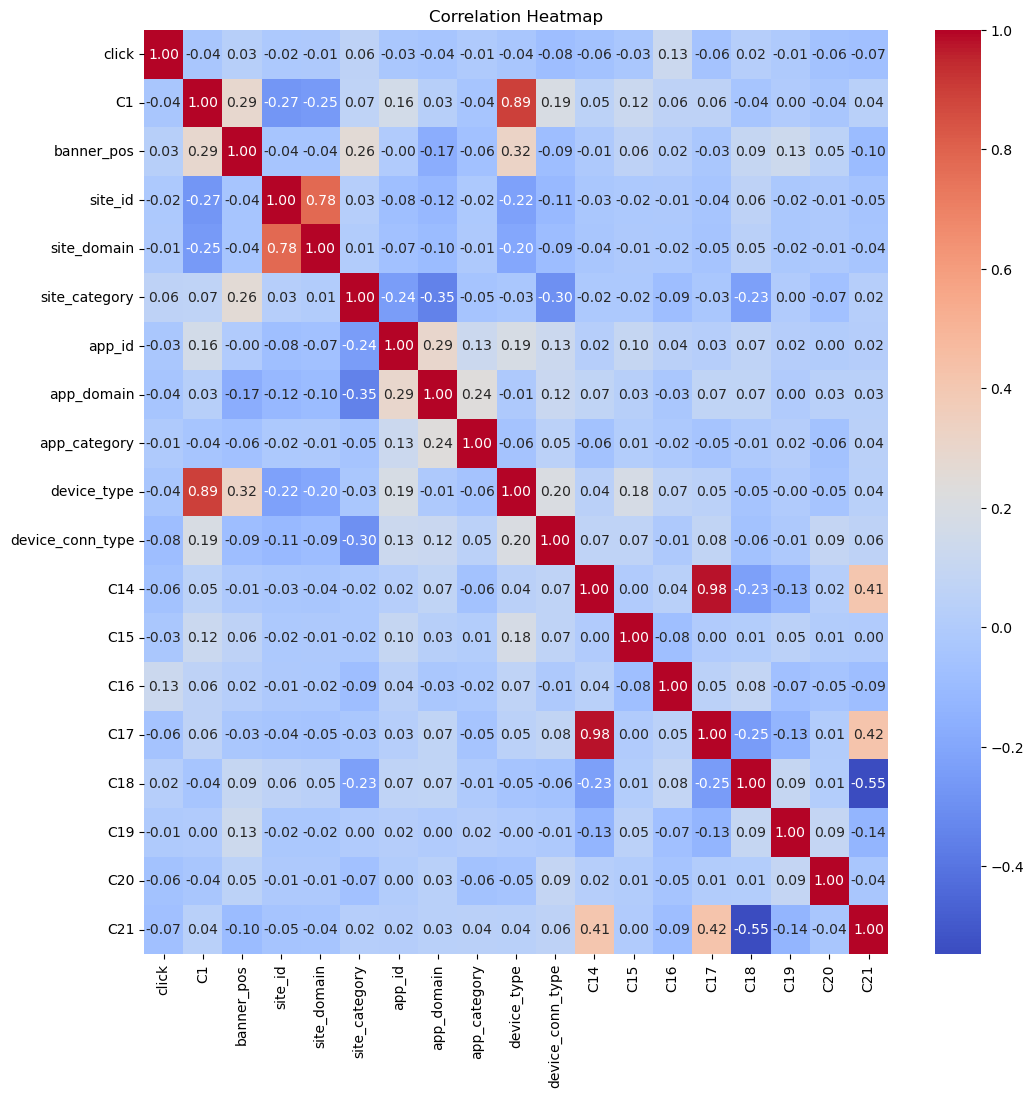

In [27]:
# Exploratory Data Analysis

# I will create a heatmap to know the coorelation between the features
import seaborn as sns

plt.figure(figsize=(12, 12))
sns.heatmap(sampled_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

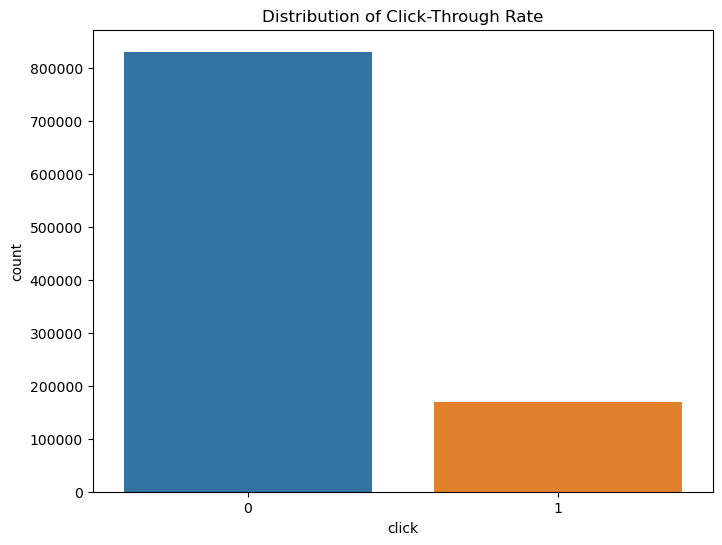

In [28]:
# Distribution of the target variable

plt.figure(figsize=(8, 6))
sns.countplot(x='click', data=sampled_df)
plt.title('Distribution of Click-Through Rate')
plt.show()

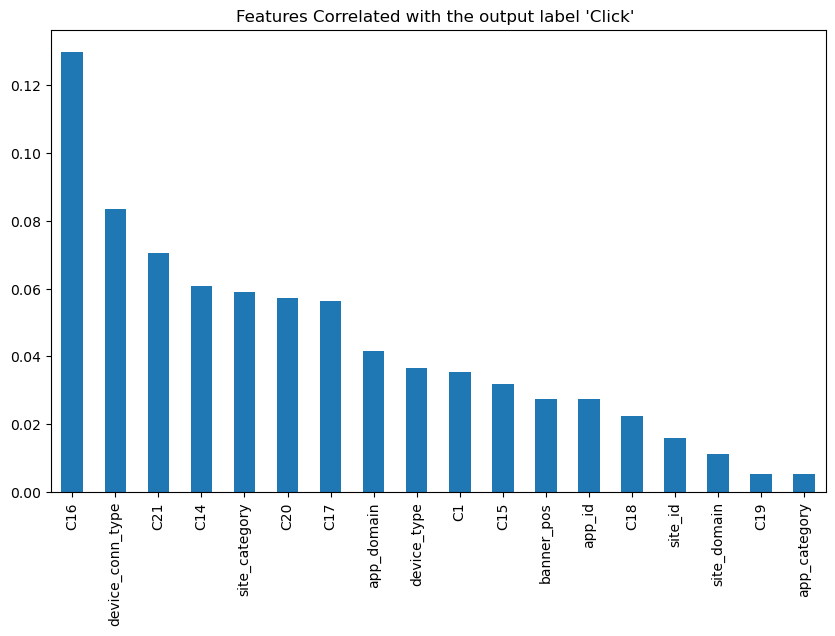

In [29]:
# Feature importance based on correlation with the target
corr_with_target = sampled_df.corr()['click'].abs().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
corr_with_target[1:].plot(kind='bar')
plt.title("Features Correlated with the output label 'Click' ")
plt.show()

In [30]:
columns = corr_with_target[1:].index.to_numpy()
columns

array(['C16', 'device_conn_type', 'C21', 'C14', 'site_category', 'C20',
       'C17', 'app_domain', 'device_type', 'C1', 'C15', 'banner_pos',
       'app_id', 'C18', 'site_id', 'site_domain', 'C19', 'app_category'],
      dtype=object)

In [223]:
# Prepare data for model training

# taking 18 features
features_with_top_corerrelation_to_output = 18
features_to_drop = columns[features_with_top_corerrelation_to_output:]

print(features_to_drop)
X = sampled_df.drop(features_to_drop, axis=1).values
Y = sampled_df['click'].values
X, Y

[]


(array([[     0,   1005,      0, ...,     39,     -1,     32],
        [     0,   1005,      0, ...,    803,     -1,    229],
        [     1,   1002,      0, ...,   1327, 100004,     52],
        ...,
        [     0,   1002,      0, ...,     35,     -1,     79],
        [     0,   1005,      1, ...,    431, 100081,    117],
        [     0,   1005,      0, ...,    431, 100077,    117]], dtype=int64),
 array([0, 0, 1, ..., 0, 0, 0], dtype=int64))

In [224]:
Y = sampled_df['click'].values
X = sampled_df.values[:, 1:]
X.shape, Y.shape

((999999, 18), (999999,))

Scaling the features, using StandarsScaler.

In [225]:
# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [226]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, Y_train

(array([[ 0.02972613, -0.56875195, -0.35105123, ..., -0.53619791,
         -1.06680991, -0.85902323],
        [ 0.02972613, -0.56875195, -0.26981423, ..., -0.53619791,
         -1.06680991, -0.71684513],
        [ 0.02972613, -0.56875195,  1.10613743, ..., -0.54758387,
          0.938084  , -0.85902323],
        ...,
        [ 0.02972613,  1.40632611, -0.05656711, ..., -0.53619791,
         -1.06680991, -0.85902323],
        [ 0.02972613, -0.56875195, -0.35105123, ...,  2.0256414 ,
          0.93632232,  0.23574815],
        [ 0.02972613, -0.56875195, -0.08195367, ...,  1.30832639,
          0.93666265, -0.50357798]]),
 array([1, 0, 0, ..., 1, 0, 0], dtype=int64))

Now, from the graph of the Distribution of the Target label, 'Click', it is clear  that the data is highly imbalanced.
So, I will use resampling technique to minimise overfitting to a specific label. I am using Random Under Sampler as it is ideal for large datasets.

In [275]:
# I am only using RUS in training data, not on test data
# Using Random Under Sampler
from imblearn.under_sampling import RandomUnderSampler
RUS = RandomUnderSampler(random_state=0)
X_train_sampled, Y_train_sampled = RUS.fit_resample(X_train, Y_train)
X_train_sampled, Y_train_sampled

(array([[ 0.02972613, -0.56875195, -0.35105123, ..., -0.54758387,
         -1.06680991, -0.85902323],
        [ 0.02972613, -0.56875195, -0.30535542, ..., -0.54758387,
         -1.06680991, -0.06282586],
        [-2.71616441, -0.56875195,  0.94366343, ..., -0.53619791,
          0.938084  , -0.73106294],
        ...,
        [ 0.02972613, -0.56875195, -0.30535542, ..., -0.54758387,
          0.93678276, -0.06282586],
        [ 0.02972613, -0.56875195, -0.30535542, ..., -0.54758387,
          0.93680278, -0.06282586],
        [ 0.02972613,  1.40632611, -0.05656711, ..., -0.53619791,
         -1.06680991, -0.85902323]]),
 array([0, 0, 0, ..., 1, 1, 1], dtype=int64))

## Task  2 (Logistic Regression)

Sigmoid
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Loss Function (BCE)
$$
L(y, \hat{y}) = -\left(y \log(\hat{y}) + (1-y) \log(1-\hat{y})\right)
$$

Gradient of Loss w.r.t. Predictions
$$
\frac{\partial L}{\partial \hat{y}} = -\frac{y}{\hat{y}} + \frac{1-y}{1-\hat{y}}
$$

Gradient of Loss w.r.t. Weights
$$
\frac{\partial L}{\partial \beta} = X^T (\hat{y} - y)
$$

Gradient of Loss w.r.t. Biases
$$
\frac{\partial L}{\partial \beta} = {\Sigma}(\hat{y} - y)
$$

Update Rule
$$
w := w - \alpha \frac{\partial L}{\partial w}
$$

In [259]:
# implementing Logistic Regression with SGD
class LogisticRegressionSGD:
    
    # class constructor
    def __init__(self, learning_rate=0.01, threshold=0.5, num_epochs=10, batch_size=1, l2_lambda=0.01):
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.l2_lambda = l2_lambda
        self.weights = None
        self.bias = None
    
    # parameters initialisation
    def initialize_parameters(self, input_dim):
        self.weights = torch.zeros(input_dim, 1)
        self.bias = torch.zeros(1)
    
    # forward pass
    def forward(self, x):
        linear_combination = torch.mm(x, self.weights) + self.bias
        return torch.sigmoid(linear_combination)
    
    # gradient calculation
    def backward(self, X_batch, y_batch, outputs):
        # Calculate gradients manually
        errors = outputs - y_batch
        grad_weights = torch.mm(X_batch.T, errors) / len(y_batch)
        grad_bias = torch.sum(errors) / len(y_batch)

        # Add L2 regularization gradient
        grad_weights += self.l2_lambda * self.weights

        return grad_weights, grad_bias

    # calculate loss (Binary Cross Entropy)
    def loss(self, y_pred, y_true):
        loss = -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
        
        l2_reg = 0.5 * self.l2_lambda * torch.sum(self.weights ** 2)
        return loss + l2_reg
 
    # fit function
    def fit(self, X, y):
        n_samples, input_dim = X.shape
        if self.weights is None or self.bias is None:
            self.initialize_parameters(input_dim)
        
        losses = []
        for epoch in range(self.num_epochs):
            total_loss = 0
            indices = torch.randperm(n_samples)
            
            for start_idx in range(0, n_samples, self.batch_size):
                batch_indices = indices[start_idx:start_idx+self.batch_size]
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]

                outputs = self.forward(X_batch)
                loss_value = self.loss(outputs, y_batch)
                
                # Manually compute gradients
                grad_weights, grad_bias = self.backward(X_batch, y_batch, outputs)

                # Update parameters
                with torch.no_grad():
                    self.weights -= self.learning_rate * grad_weights
                    self.bias -= self.learning_rate * grad_bias
                
                total_loss += loss_value.item() * len(batch_indices)
            
            losses.append(total_loss)
            print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {total_loss/n_samples:.4f}')
        plt.figure(figsize=(10, 5))
        plt.plot(range(self.num_epochs), losses)
        plt.title('Loss vs Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    # predict
    def predict(self, X):
        with torch.no_grad():
            probabilities = self.forward(X)
            predictions = (probabilities >= self.threshold).float()
        return predictions

In [260]:
X_train_sampled = torch.FloatTensor(X_train_sampled)
Y_train_sampled = torch.FloatTensor(Y_train_sampled).reshape(-1, 1)

In [261]:
Y_train_sampled.shape, X_train_sampled.shape

(torch.Size([271778, 1]), torch.Size([271778, 18]))

Epoch [1/7], Loss: 0.6640
Epoch [2/7], Loss: 0.6637
Epoch [3/7], Loss: 0.6637
Epoch [4/7], Loss: 0.6636
Epoch [5/7], Loss: 0.6636
Epoch [6/7], Loss: 0.6636
Epoch [7/7], Loss: 0.6637


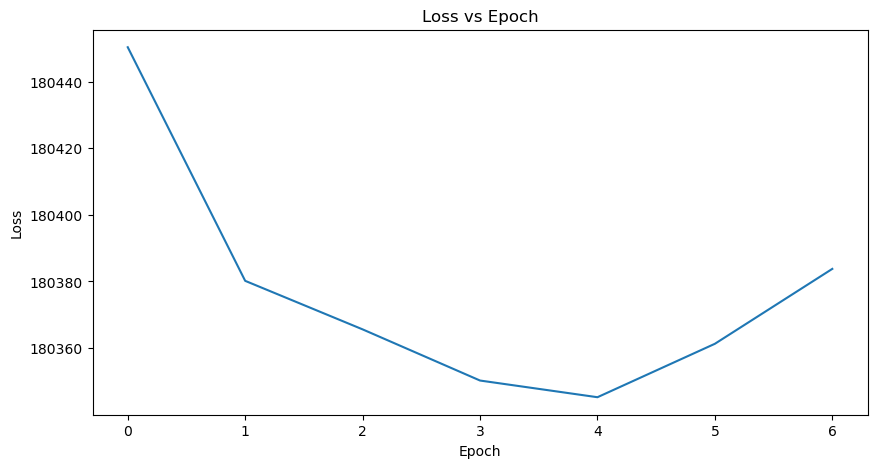

In [266]:
# Train the model

learning_rate=0.001
threshold=0.5
num_epochs=7
batch_size=1
l2_lambda=0.000001


LogisticRegression = LogisticRegressionSGD(learning_rate, threshold, num_epochs, batch_size, l2_lambda)
LogisticRegression.fit(X_train_sampled, Y_train_sampled)

Evaluating on Test Data. It is disjoint from the training data as asked.

In [267]:
# Evaluation
Y_pred = LogisticRegression.predict(torch.FloatTensor(X_test))

In [268]:
Y_pred

tensor([[0.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [269]:
# Calculate precision-recall curve
from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)
prediction_auc = auc(recall, precision)

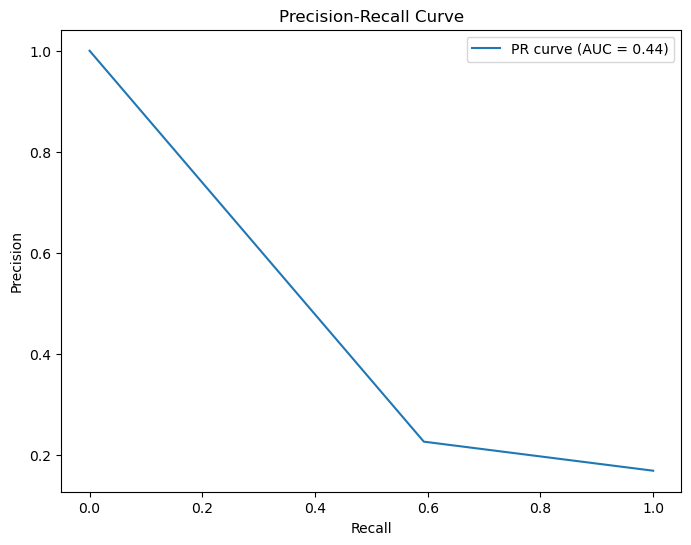

In [270]:
# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AUC = {prediction_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

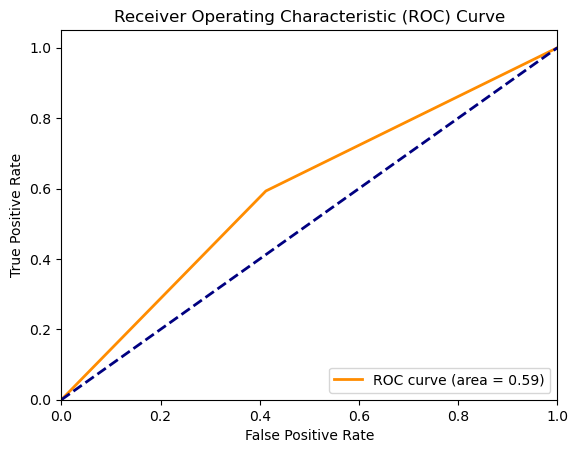

In [271]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [272]:
# confusion matrix
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.88      0.59      0.70    166084
           1       0.23      0.59      0.33     33916

    accuracy                           0.59    200000
   macro avg       0.55      0.59      0.52    200000
weighted avg       0.77      0.59      0.64    200000



In [273]:
Y_pred

tensor([[0.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

Confusion Matrix:
 [[97617 68467]
 [13804 20112]]


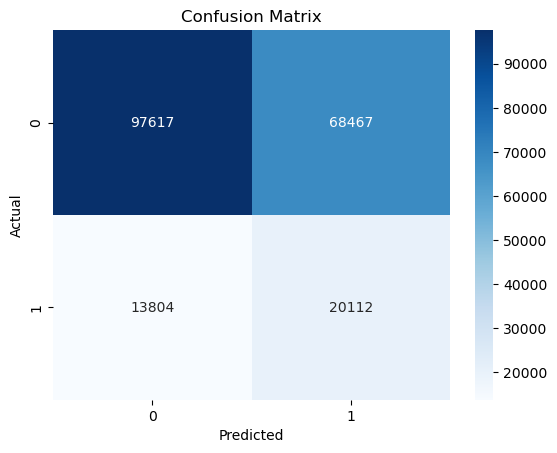

In [274]:
from sklearn.metrics import confusion_matrix

# Add confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()